# <font color=darkcyan> MCMC algorithms</font>
#### <font color=darkorange>Metropolis-Hastings, MALA,  Hamiltonian Monte Carlo... </font>

In [17]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [18]:
"""""""""""""""""
Required packages
"""""""""""""""""
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm

In a Bayesian setting, a parameter $x$ is embedded with a prior distribution $\pi$ and the observations are given by a probabilistic model:

$$
Y\sim \ell(\cdot|x)\,.
$$


The inference is then based on the posterior distribution:
$$
\pi(x|Y) = \frac{\pi(x)\ell(Y|x)}{\int\pi(u)\ell(Y|u)\mathrm{d} u}\,.
$$


In most cases the normalizing constant is not tractable:
$$
\pi(x|Y) \propto \pi(x)\ell(Y|x)\,.
$$

``Markov chain Monte Carlo (MCMC) algorithms`` provide solutions to sample from posterior distributions. ``Hamiltonian Monte Carlo (HMC)`` is a MCMC algorithm that uses gradient information to scale better to higher dimensions. It is used by software like [PyMC3](https://pymc.io/) and [Stan](https://mc-stan.org/). 

Some references on MCMC...
- **Douc R., Moulines E. and Stoffer D.**, Nonlinear time series: theory, methods and applications with R example, 2014, Chapman \& Hall.
- **Michael Betancourt, [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)** A thorough, readable reference that is the main source here

### <font color=darkorange> A few simple models </font>

In the following, the target density is written $\pi$. We define below two examples of target densities $\pi$ which will be used to assess the efficiency of the proposed MCMC algorithm.

<font color=darkred> Write a function returning the opposite of the log probability density of </font>
    
<font color=darkred>    i) a Gaussian random variable with mean mu and covariance matrix sigma; </font>
    
<font color=darkred>    ii) a mixture of probability density functions. </font>

In [19]:
def multi_gauss(mu, sigma):
    """
    Inputs
    ----------
    mu: mean of the Gaussian distribution
    sigma: covariance matrix of the Gaussian distribution
    
    Outputs
    -------
    logp: opposite of the loglikelihood
    """

    def logp(x):
        k   = mu.shape[0]
        cst       = k * np.log(2 * np.pi)
        det       = np.log(np.linalg.det(sigma))
        quad_term = np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), x - mu)
        return (cst +  det + quad_term) * 0.5
    
    return logp

def mixture(log_prob, weights):
    """
    Inputs
    ----------
    log_prob: opposite of the likelihood of each term
    weights: weights of the components of the mixture
    
    Outputs
    -------
    logp: opposite of the loglikelihood of the mixture
    """
    
    def logp(x):
        likelihood = 0
        for j in range(np.size(weights)):
            log_marginal = -log_prob[j](x)
            likelihood   = likelihood + weights[j]*np.exp(log_marginal)
        
        return -np.log(likelihood)

    return logp

In [20]:
grid_lim = 6
# grid on which the target pdf is displayed
grid_plot = (-grid_lim, grid_lim, -grid_lim, grid_lim)
# coordinates chosen on this grid
nb_points = 100

xplot = np.linspace(-grid_lim, grid_lim, nb_points)
yplot = np.linspace(-grid_lim, grid_lim, nb_points)
Xplot, Yplot = np.meshgrid(xplot, yplot)

## <font color=darkcyan> Metropolis-Hastings algorithm </font>

``Objective target density:`` $\pi(\cdot|Y)$.

``Instrumental transition density:`` $q(x,y)$.

At each iteration $k\geqslant 0$, generate $Z_{k+1} \sim q(X_k,\cdot)$.

Set $X_{k+1} = Z_{k+1}$ with probability $\alpha(X_k,Z_{k+1})$ and  $X_{k+1} = X_k$ with probability $1-\alpha(X_k,Z_{k+1})$, where 

$$
\alpha(x,y) = 1\wedge\frac{\pi(y|Y)}{\pi(x|Y)}\frac{q(y,x)}{q(x,y)}\,.
$$

<font color=darkred> Write a function which returns samples from Metropolis-Hastings algorithm with Gaussian proposal density.</font>

In [21]:
def HM_monte_carlo(n_samples, log_prob, initial_state, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return
    log_prob: opposite of the loglikelihood to sample from
    initial_state: initial sample
    step_size: standard deviation of the proposed moves
    
    Outputs
    -------
    samples: samples from the MCMC algorithm
    accepted: array of 0 and 1 to display which proposed moves have been accepted
    """
    initial_state = np.array(initial_state)
    
    samples  = [initial_state]
    accepted = []

    size = (n_samples,) + initial_state.shape[:1]
    
    # random variable to sample proposed moves
    epsilon = st.norm(0, 1).rvs(size)
    
    for noise in tqdm(epsilon):
        
        q_new = samples[-1] + step_size*noise
       
        # acceptance rate
        old_log_p = log_prob(samples[-1]) 
        new_log_p = log_prob(q_new) 
        
        if np.log(np.random.rand()) < old_log_p - new_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(accepted),)

## <font color=darkcyan> Metropolis Adjusted Langevin algorithm (MALA) </font>

``Objective target density:`` $\pi(\cdot|Y)$.

At each iteration $k\geqslant 0$, generate $Z_{k+1} \sim X_k + \frac{\sigma}{2}\nabla\log\pi(X_k|Y) + \sigma \varepsilon_{k+1}$.

Set $X_{k+1} = Z_{k+1}$ with probability $\alpha(X_k,Z_{k+1})$ and  $X_{k+1} = X_k$ with probability $1-\alpha(X_k,Z_{k+1})$, where 

$$
\alpha(x,y) = 1\wedge\frac{\pi(y|Y)}{\pi(x|Y)}\frac{q(y,x)}{q(x,y)}\,,
$$

where $q(x,y)$ is the Gaussian pdf with mean $x + \frac{\sigma}{2}\nabla\log\pi(x|Y)$ and variance $\sigma^2 I_d$.

<font color=darkred> Write a function which returns samples from MALA algorithm.</font>

In [22]:
def MALA_monte_carlo(n_samples, log_prob, initial_state, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return
    log_prob: opposite of the loglikelihood to sample from
    initial_state: initial sample
    step_size: standard deviation of the proposed moves
    
    Outputs
    -------
    samples: samples from the MCMC algorithm
    accepted: array of 0 and 1 to display which proposed moves have been accepted
    """
    initial_state = np.array(initial_state)

    gradV = grad(log_prob)

    samples  = [initial_state]
    accepted = []

    size = (n_samples,) + initial_state.shape[:1]
    
    # random variable to sample proposed moves
    epsilon = st.norm(0, 1).rvs(size)
    
    for noise in tqdm(epsilon):
        
        grad_new = gradV(samples[-1])
        mean_new = samples[-1] - 0.5*step_size*grad_new
        
        q_new    = mean_new + step_size*noise
       
        grad_y   = gradV(q_new)
        mean_y   = q_new - 0.5*step_size*grad_y
        
        # acceptance rate
        old_log_p = log_prob(samples[-1]) + 0.5*np.dot(q_new-mean_new,q_new-mean_new)/(step_size**2)
        new_log_p = log_prob(q_new) + 0.5*np.dot(samples[-1]-mean_y,samples[-1]-mean_y)/(step_size**2)
        
        if np.log(np.random.rand()) < old_log_p - new_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(accepted),)

## <font color=darkcyan> Hamiltonian Monte Carlo </font>

### <font color=darkorange> Framework </font>

The unknown  parameters are gathered into a _position_ variable, usually written $\mathbf{q}$. 
An auxiliary variable, called ``momentum`` and written $\mathbf{p}$, is introduced to define the extended joint probability distribution 

$$
\pi(\mathbf{q}, \mathbf{p}|Y) =  \pi(\mathbf{q}|Y) \pi(\mathbf{p} | \mathbf{q},Y)\,,
$$

In most cases $\pi(\mathbf{p} | \mathbf{q},Y)$ is the probability density of a Gaussian random variable with mean $0$ and variance $M$.

The ``Hamiltonian`` associated with this model is  $H(\mathbf{q}, \mathbf{p}|Y) = -\log \pi(\mathbf{q}, \mathbf{p}|Y)$ so that

$$
H(\mathbf{q}, \mathbf{p}|Y) = -\log \pi(\mathbf{p} | \mathbf{q},Y) - \log \pi(\mathbf{q}|Y) = K(\mathbf{p}, \mathbf{q}|Y) + V(\mathbf{q}|Y)\,,
$$

where $K(\mathbf{p}, \mathbf{q}|Y)$ is called the _kinetic energy_, and $V(\mathbf{q}|Y)$ is called the _potential energy_.

The dynamics of the system $(\mathbf{q}, \mathbf{p})$ is assumed to follow _Hamilton's equations_:

$$
\frac{\mathrm{d} \mathbf{q}}{\mathrm{d}t} = \frac{\partial H}{\partial \mathbf{p}} = \frac{\partial K}{\partial \mathbf{p}} + \frac{\partial V}{\partial \mathbf{p}}\\
\frac{\mathrm{d} \mathbf{p}}{\mathrm{d}t} = -\frac{\partial H}{\partial \mathbf{q}}= -\frac{\partial K}{\partial \mathbf{q}} + \frac{\partial V}{\partial \mathbf{q}}
$$


When $\pi(\mathbf{p} | \mathbf{q},Y)$ is the probability density of a Gaussian random variable with mean $0$ and variance $M$, this yields

$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T M^{-1}\mathbf{p} + \log |M| + \text{C},
$$

In the specific case of $M=I$,  
$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T \mathbf{p} + \text{C}\,,
$$

so that

$$
\frac{\partial K}{\partial \mathbf{p}} = \mathbf{p} \quad \mathrm{and} \quad \frac{\partial K}{\partial \mathbf{q}} = \mathbf{0}\,.
$$


Finally,

$$
\frac{\mathrm{d} \mathbf{q}}{\mathrm{d}t}  = \mathbf{p}\quad \mathrm{and} \quad \frac{\mathrm{d} \mathbf{p}}{\mathrm{d}t} = - \frac{\partial V}{\partial \mathbf{q}}\,.
$$

<font color=darkred> Write a function returning the positions and momemtums of a Euler scheme based interator </font>

In [23]:
def euler_integrator(q, p, gradientV, T, step):
    """
    Inputs
    ----------
    q: initial position
    p: initial momentum
    gradientV: gradient of the velocity
    T: time horizon
    step: step size to discretize the ODE
    
    Outputs
    -------
    q, p: last position and last momentum
    posisions: sequence of positions produced by the Euler based scheme integrator
    momentums: sequence of momentums produced by the Euler based scheme integrator
    """
    
    q, p      = np.copy(q), np.copy(p)
    pos, moms = [np.copy(q)], [np.copy(p)]

    vq = gradientV(q)
    nb_steps = int(T / step)
    
    for it in range(nb_steps):
        p = p - step * vq
        q = q + step * p  
        pos.append(np.copy(q))
        vq = gradientV(q)
        moms.append(np.copy(p))

    return q, -p, np.array(pos), np.array(moms)

### <font color=darkorange> The Leapfrog integrator </font>
The leapfrog integrator may be used to approximate the ordinary differential equations (ODE) $q$ and $p$ are solutions to. 

It involves updating the momentum `p` a half step, then the position `q` a whole step, and then finish updating `p` the other half of the step.

A momentum flip at the end is required to preserve the reversibility of the algorithm.

<font color=darkred> Write a function returning the positions and momemtums of a leapfrog interator </font>

In [24]:
def leapfrog_integrator(q, p, gradientV, T, step):
    """
    Inputs
    ----------
    q: initial position
    p: initial momentum
    gradientV: gradient of the velocity
    T: time horizon
    step: step size to discretize the ODE
    
    Outputs
    -------
    q, p: last position and last momentum
    posisions: sequence of positions produced by the leapfrog integrator
    momentums: sequence of momentums produced by the leapfrog integrator
    """
    
    q, p      = np.copy(q), np.copy(p)
    pos, moms = [np.copy(q)], [np.copy(p)]

    vq = gradientV(q)
    nb_steps = int(T / step)
    
    for it in range(nb_steps):
        p = p - 0.5*step * vq 
        q = q + step * p  
        pos.append(np.copy(q))
        vq = gradientV(q)
        p = p - 0.5*step * vq
        moms.append(np.copy(p))

    return q, -p, np.array(pos), np.array(moms)

<font color=darkred> Illustrate the points proposed by the leapfrog integrator along a trajectory for a 2-dimensional Gaussian distribution. </font>

In [25]:
log_density = multi_gauss(np.zeros(2), np.eye(2))
gradV = grad(log_density)

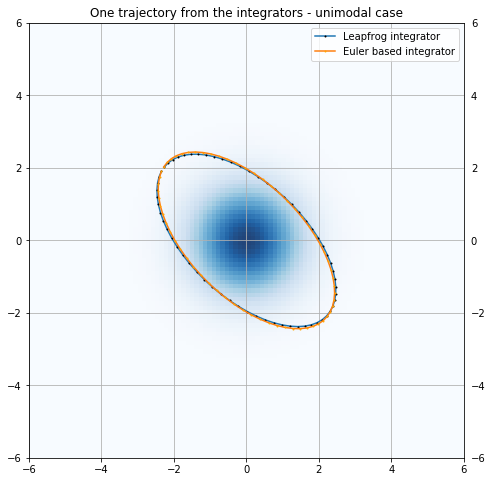

In [26]:
q, p = np.random.randn(2, 2)
_, _, positions_leap, momentums_leap = leapfrog_integrator(q, p, gradV, 2 * np.pi, 0.1)
_, _, positions_euler, momentums_euler = euler_integrator(q, p, gradV, 2 * np.pi, 0.1)
fig = plt.figure(figsize=(8,8))
plt.title('One trajectory from the integrators - unimodal case')

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_density(np.array((Xplot[i][j], Yplot[i][j]))))

plt.imshow(Zplot, alpha=0.9, extent = grid_plot, cmap='Blues', origin='top')
plt.plot(positions_leap[:,0], positions_leap[:,1], marker='o', markersize = 1, markeredgecolor='black', label = 'Leapfrog integrator')
plt.plot(positions_euler[:,0], positions_euler[:,1], marker='o', markersize = 1, markeredgecolor='orange', label = 'Euler based integrator')
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

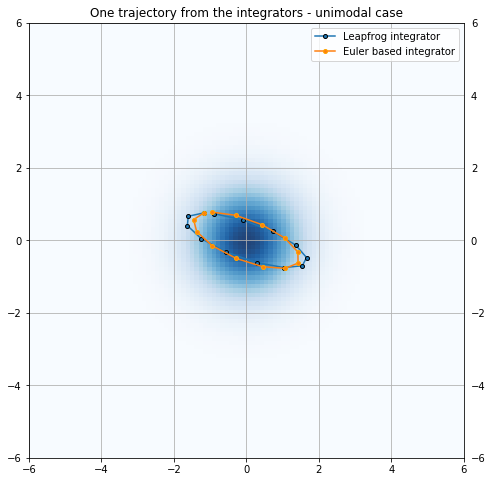

In [27]:
q, p = np.random.randn(2, 2)
_, _, positions_leap, momentums_leap = leapfrog_integrator(q, p, gradV, 2 * np.pi, 0.5)
_, _, positions_euler, momentums_euler = euler_integrator(q, p, gradV, 2 * np.pi, 0.5)
fig = plt.figure(figsize=(8,8))
plt.title('One trajectory from the integrators - unimodal case')
plt.imshow(Zplot, alpha=0.9, extent = grid_plot, cmap='Blues', origin='top')
plt.plot(positions_leap[:,0], positions_leap[:,1], marker='o', markersize = 4, markeredgecolor='black', label = 'Leapfrog integrator')
plt.plot(positions_euler[:,0], positions_euler[:,1], marker='o', markersize = 4, markeredgecolor='orange', label = 'Euler based integrator')
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

<font color=darkred> Display several trajectories of the leapfrog integrator for a 2-dimensional Gaussian target distribution. </font>

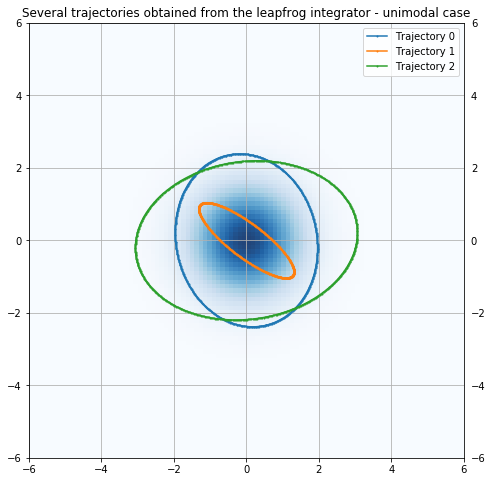

In [28]:
fig = plt.figure(figsize=(8,8))
plt.title('Several trajectories obtained from the leapfrog integrator - unimodal case')
positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    _, _, pos, moms = leapfrog_integrator(q, p, gradV, 2 * np.pi, 0.01)
    positions.append(pos)
    momentums.append(moms)

plt.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap = 'Blues', origin = 'top')

for idx_traj in range(3):
    plt.plot(positions[idx_traj][:,0], positions[idx_traj][:,1], marker='o', markersize = 1, label = 'Trajectory %g'%idx_traj)
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

<font color=darkred> Display several trajectories of the leapfrog integrator for a target defined as a mixture of 2-dimensional Gaussian distributions. </font>

In [31]:
mu1 = 2*np.ones(2)
cov1 = np.array([[1., 0.5],
                [0.5, 1.]])
mu2 = -mu1
cov2 = np.array([[1., -0.1],
                [-0.1, 1.]])

mu3 = np.array([-1.5, 2.2])
cov3 = 0.8 * np.eye(2)

logp  = mixture([multi_gauss(mu1, cov1), multi_gauss(mu2, cov2), multi_gauss(mu3, cov3)], [0.25, 0.35, 0.4])
gradV = grad(logp)


positions, momentums = [], []
for it in range(5):
    q, p = np.random.randn(2, 2)
    _, _, pos, moms = leapfrog_integrator(q, p, gradV, 4 * np.pi, 0.01)
    positions.append(pos)
    momentums.append(moms)

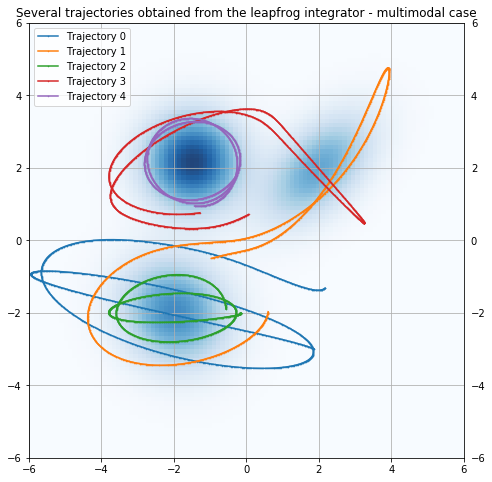

In [32]:
fig = plt.figure(figsize=(8,8))
plt.title('Several trajectories obtained from the leapfrog integrator - multimodal case')

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-logp(np.array((Xplot[i][j], Yplot[i][j]))))

plt.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap = 'Blues', origin = 'top')

for idx_traj in range(5):
    plt.plot(positions[idx_traj][:,0], positions[idx_traj][:,1], marker='.', markersize = 1, label = 'Trajectory %g'%idx_traj)
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

### <font color=darkorange> The Hamiltonian loop </font>

<font color=darkred> Use the leapfrog function to write a Hamiltonian loop i.e. a Hamiltonian MCMC with a generic target distribution. </font>

In [33]:
def hamiltonian_monte_carlo(n_samples, log_prob, initial_position, T = 1, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return.
    log_prob: opposite of the target log probability.
    initial_position: a place to start sampling from.
    T: length of leapfrog integration.
    step_size: step size of the integration scheme.
    
    Outputs
    -------
    samples: samples produced by the HMC.
    sample_positions: positions obtained by the leapfrog integrator at each time step.
    sample_momentums: momentums obtained by the leapfrog integrator at each time step.
    accepted: array of 0 and 1 to display which proposed moves have been accepted.
    """
    initial_position = np.array(initial_position)
    
    gradV = grad(log_prob)

    samples = [initial_position]
    sample_positions, sample_momentums = [], []
    accepted = []

    size = (n_samples,) + initial_position.shape[:1]
    
    # all momentums
    momentum = st.norm(0, 1).rvs(size)
    
    for p0 in tqdm(momentum):
        q_new, p_new, positions, momentums = leapfrog_integrator(samples[-1], p0, gradV, 2 * np.random.rand() * T,step_size)
        sample_positions.append(positions)
        sample_momentums.append(momentums)

        # acceptance rate
        old_log_p = log_prob(samples[-1]) - np.sum(st.norm(0, 1).logpdf(p0))
        new_log_p = log_prob(q_new) - np.sum(st.norm(0, 1).logpdf(p_new))
        
        if np.log(np.random.rand()) < old_log_p - new_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(sample_positions),np.array(sample_momentums),np.array(accepted),)

<font color=darkred> Display several trajectories of the HMC loop for a Gaussian target distribution </font>

<font color=darkred>i) Illustrate the influence of the total length of the leapfrog integrator. </font>

<font color=darkred>ii) Illustrate the influence of the step size of the leapfrog integrator. </font>

<font color=darkred>iii) Compare the performance with a HM algorithm. </font>

<font color=darkred>iv) Compare the performance with a MALA algorithm. </font>

In [34]:
log_p = multi_gauss(np.zeros(2), np.eye(2))

n_samples = 150
step_size = 0.1


In [35]:
all_T = [1, 5, 10, 15]
samples_HMC = []
positions_HMC = []
momentums_HMC = []

for T in all_T:
    samples, positions, momentums, accepted = hamiltonian_monte_carlo(n_samples, log_p, np.random.randn(2), T, step_size)
    samples_HMC.append(samples)
    positions_HMC.append(positions)
    momentums_HMC.append(momentums)

 15%|█▌        | 23/150 [00:01<00:07, 17.27it/s]


KeyboardInterrupt: 

In [24]:
samples_HM, accepted_HM = HM_monte_carlo(5*n_samples, log_p, np.random.randn(2), 0.1)

100%|██████████| 750/750 [00:00<00:00, 14180.04it/s]


In [25]:
samples_Mala, accepted_Mala = MALA_monte_carlo(5*n_samples, log_p, np.random.randn(2), 0.1)

100%|██████████| 750/750 [00:00<00:00, 1115.53it/s]


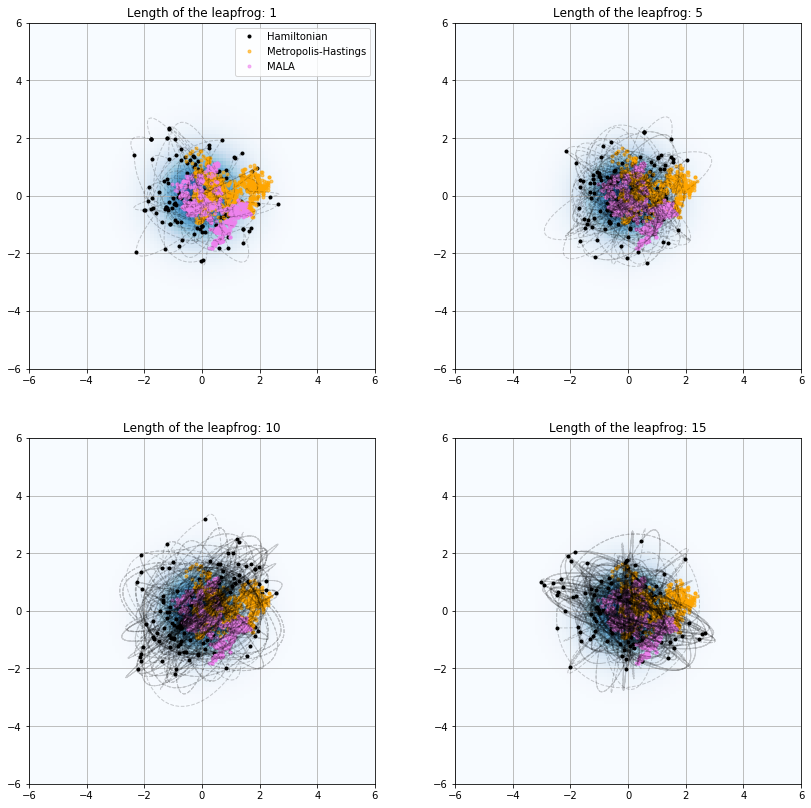

In [27]:
fig = plt.figure(figsize=(14,14))
ax1  = fig.add_subplot(221)
ax2  = fig.add_subplot(222) 
ax3  = fig.add_subplot(223)
ax4  = fig.add_subplot(224)
ax1.set_title('Length of the leapfrog: %g'%all_T[0])
ax2.set_title('Length of the leapfrog: %g'%all_T[1])
ax3.set_title('Length of the leapfrog: %g'%all_T[2])
ax4.set_title('Length of the leapfrog: %g'%all_T[3])

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_p(np.array((Xplot[i][j], Yplot[i][j]))))

ax1.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax1.plot(samples_HMC[0][:,0], samples_HMC[0][:,1], '.', color='black', label = 'Hamiltonian')
ax1.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6, label = 'Metropolis-Hastings')
ax1.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6, label = 'MALA')
ax1.grid(True)
for i in range(n_samples):
    ax1.plot(positions_HMC[0][i][:, 0], positions_HMC[0][i][:, 1], 'k--', lw = 1, alpha = 0.2)
ax1.legend()

ax2.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax2.plot(samples_HMC[1][:,0], samples_HMC[1][:,1], '.', color='black')
ax2.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax2.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax2.grid(True)
for i in range(n_samples):
    ax2.plot(positions_HMC[1][i][:, 0], positions_HMC[1][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax3.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax3.plot(samples_HMC[2][:,0], samples_HMC[2][:,1], '.', color='black')
ax3.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax3.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax3.grid(True)
for i in range(n_samples):
    ax3.plot(positions_HMC[2][i][:, 0], positions_HMC[2][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax4.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax4.plot(samples_HMC[3][:,0], samples_HMC[3][:,1], '.', color='black')
ax4.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax4.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax4.grid(True)
for i in range(n_samples):
    ax4.plot(positions_HMC[3][i][:, 0], positions_HMC[3][i][:, 1], 'k--', lw = 1, alpha = 0.2)

<font color=darkred> Display several trajectories of the HMC algorithm for a target defined as a mixture of Gaussian distributions. </font>

<font color=darkred>i) Illustrate the influence of the total length of the leapfrog integrator. </font>

<font color=darkred>ii) Illustrate the influence of the step size of the leapfrog integrator. </font>

<font color=darkred>iii) Compare the performance with a HM algorithm. </font>

<font color=darkred>iv) Compare the performance with a MALA algorithm. </font>

In [28]:
mu1 = 2*np.ones(2)
cov1 = np.array([[1., 0.5],
                [0.5, 1.]])
mu2 = -mu1
cov2 = np.array([[1., -0.1],
                [-0.1, 1.]])

mu3 = np.array([-1.5, 2.2])
cov3 = 0.8 * np.eye(2)

mu4 = np.array([2.5, -4.2])
cov4 = 0.5 * np.eye(2)

log_p = mixture([multi_gauss(mu1, cov1), multi_gauss(mu2, cov2), multi_gauss(mu3, cov3), multi_gauss(mu4, cov4)], [0.25, 0.35, 0.3,0.1])

<font color=darkred>Total length of the leapfrog integrator. </font>

In [29]:
n_samples = 150
step_size = 0.1
all_T = [1, 5, 10, 15]
samples_HMC = []
positions_HMC = []
momentums_HMC = []

for T in all_T:
    samples, positions, momentums, accepted = hamiltonian_monte_carlo(n_samples, log_p, np.random.randn(2), T, step_size)
    samples_HMC.append(samples)
    positions_HMC.append(positions)
    momentums_HMC.append(momentums)

100%|██████████| 150/150 [00:36<00:00,  3.38it/s]


In [30]:
samples_HM, accepted_HM = HM_monte_carlo(5*n_samples, log_p, np.random.randn(2), step_size)

100%|██████████| 750/750 [00:00<00:00, 3686.36it/s]


In [31]:
samples_Mala, accepted_Mala = MALA_monte_carlo(5*n_samples, log_p, np.random.randn(2), step_size)

100%|██████████| 750/750 [00:02<00:00, 261.82it/s]


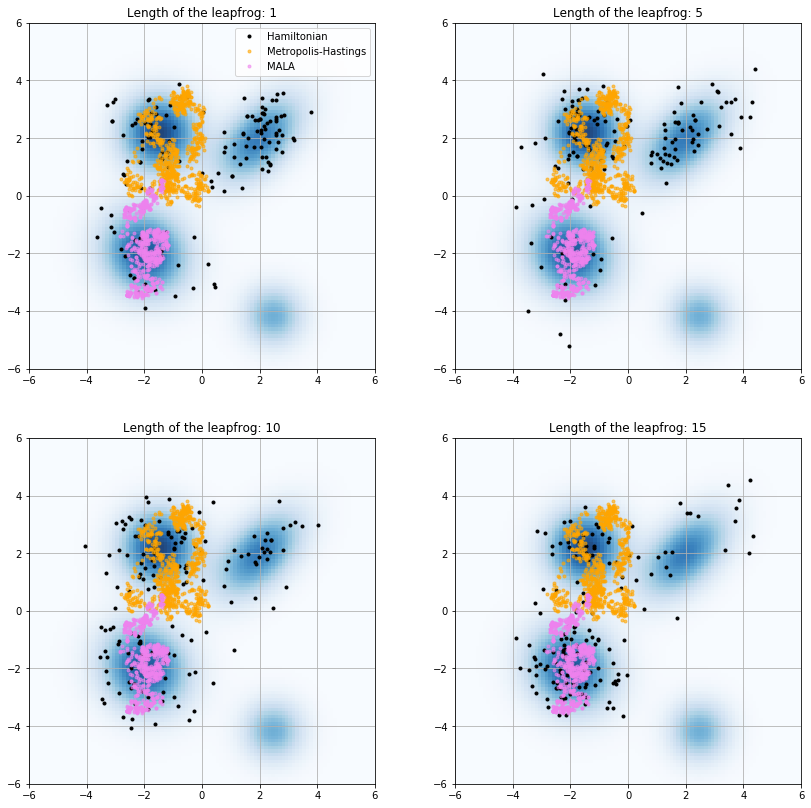

In [32]:
fig = plt.figure(figsize=(14,14))
ax1  = fig.add_subplot(221)
ax2  = fig.add_subplot(222) 
ax3  = fig.add_subplot(223)
ax4  = fig.add_subplot(224)
ax1.set_title('Length of the leapfrog: %g'%all_T[0])
ax2.set_title('Length of the leapfrog: %g'%all_T[1])
ax3.set_title('Length of the leapfrog: %g'%all_T[2])
ax4.set_title('Length of the leapfrog: %g'%all_T[3])

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_p(np.array((Xplot[i][j], Yplot[i][j]))))

ax1.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax1.plot(samples_HMC[0][:,0], samples_HMC[0][:,1], '.', color='black', label = 'Hamiltonian')
ax1.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6, label = 'Metropolis-Hastings')
ax1.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6, label = 'MALA')
ax1.grid(True)
#for i in range(n_samples):
#    ax1.plot(positions_HMC[0][i][:, 0], positions_HMC[0][i][:, 1], 'k--', lw = 1, alpha = 0.2)
ax1.legend()
    
ax2.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax2.plot(samples_HMC[1][:,0], samples_HMC[1][:,1], '.', color='black')
ax2.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax2.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax2.grid(True)
#for i in range(n_samples):
#    ax2.plot(positions_HMC[1][i][:, 0], positions_HMC[1][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax3.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax3.plot(samples_HMC[2][:,0], samples_HMC[2][:,1], '.', color='black')
ax3.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax3.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax3.grid(True)
#for i in range(n_samples):
#    ax3.plot(positions_HMC[2][i][:, 0], positions_HMC[2][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax4.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax4.plot(samples_HMC[3][:,0], samples_HMC[3][:,1], '.', color='black')
ax4.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax4.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax4.grid(True)
#for i in range(n_samples):
#    ax4.plot(positions_HMC[3][i][:, 0], positions_HMC[3][i][:, 1], 'k--', lw = 1, alpha = 0.2)

<font color=darkred>Step-size of the leapfrog integrator. </font>

In [ ]:
n_samples = 250
step_size = 0.01
all_epsilon = [0.005,0.01,0.05,0.1]
T           = 5
samples_HMC = []
positions_HMC = []
momentums_HMC = []

for epsilon in all_epsilon:
    samples, positions, momentums, accepted = hamiltonian_monte_carlo(n_samples, log_p, np.random.randn(2), T, epsilon)
    samples_HMC.append(samples)
    positions_HMC.append(positions)
    momentums_HMC.append(momentums)

In [ ]:
samples_HM, accepted_HM = HM_monte_carlo(n_samples, log_p, np.random.randn(2), step_size)

In [ ]:
samples_Mala, accepted_Mala = MALA_monte_carlo(n_samples, log_p, np.random.randn(2), step_size)

In [ ]:
fig = plt.figure(figsize=(14,14))
ax1  = fig.add_subplot(221)
ax2  = fig.add_subplot(222) 
ax3  = fig.add_subplot(223)
ax4  = fig.add_subplot(224)
ax1.set_title('Step-size of the leapfrog: %g'%all_epsilon[0])
ax2.set_title('Step-size of the leapfrog: %g'%all_epsilon[1])
ax3.set_title('Step-size of the leapfrog: %g'%all_epsilon[2])
ax4.set_title('Step-size of the leapfrog: %g'%all_epsilon[3])

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_p(np.array((Xplot[i][j], Yplot[i][j]))))

ax1.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax1.plot(samples_HMC[0][:,0], samples_HMC[0][:,1], '.', color='black', label = 'Hamiltonian')
ax1.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6, label = 'Metropolis-Hastings')
ax1.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6, label = 'MALA')
ax1.grid(True)
for i in range(n_samples):
    ax1.plot(positions_HMC[0][i][:, 0], positions_HMC[0][i][:, 1], 'k--', lw = 1, alpha = 0.2)
ax1.legend()
    
ax2.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax2.plot(samples_HMC[1][:,0], samples_HMC[1][:,1], '.', color='black')
ax2.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax2.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax2.grid(True)
for i in range(n_samples):
    ax2.plot(positions_HMC[1][i][:, 0], positions_HMC[1][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax3.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax3.plot(samples_HMC[2][:,0], samples_HMC[2][:,1], '.', color='black')
ax3.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax3.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax3.grid(True)
for i in range(n_samples):
    ax3.plot(positions_HMC[2][i][:, 0], positions_HMC[2][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax4.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax4.plot(samples_HMC[3][:,0], samples_HMC[3][:,1], '.', color='black')
ax4.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax4.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax4.grid(True)
for i in range(n_samples):
    ax4.plot(positions_HMC[3][i][:, 0], positions_HMC[3][i][:, 1], 'k--', lw = 1, alpha = 0.2)

### <font color=darkorange> Parameters tuning </font>

<font color=darkred>Analyze the optimal tuning of the HMC parameters: variance matrix of the momentums, step-size, length of the symplectic integration...</font>